In [4]:
import matplotlib
%matplotlib inline
import random
import scipy.stats as stats
import pandas as pd
import numpy
import copy
import json
import ast
import math
import itertools
import scipy.stats as stats
import matplotlib.pyplot as pl
from operator import itemgetter, attrgetter, methodcaller
from scipy.stats import poisson
from docx import Document
from docx.text.run import Font, Run
from docx.dml.color import ColorFormat
from docx.shared import RGBColor

def get_num_categories(attributeNamesAndCategories):
    num_categories = 1
    for i in attributeNamesAndCategories.items():
        num_categories *= i[1]
    return num_categories    
    
def determineGroups(attributeNamesAndCategories):
    elementSets = []
    groups = []
    for attr, cardinality in attributeNamesAndCategories.items():
        elementSets.append(list(range(0, cardinality)))

    groups = list(itertools.product(*elementSets))
    return groups

def get_minimum_targets(categories, p, alpha, k):
    positions = numpy.array(list(range(k))) + 1;
    minimum_targets = [];
    tau = numpy.zeros(len(categories)-1);

    for i in positions:
        tau_p = multinomial_icdf_continuous(len(p), i, p , alpha, tau)[1:]
        minimum_targets.append(numpy.array(tau_p));
        tau = copy.copy(tau_p);
    df = pd.DataFrame(data=(numpy.array(minimum_targets)).astype(int))
    df.columns = p[1:]
    df.index = numpy.array(range(k))+1
    df.to_html("minimum_target_table.html")    
    return minimum_targets    

def separate_groups(data_set, categories, attributeItems):
    num_categories = len(categories)
    separateByGroups = [[] for _ in range(num_categories)]
    
    for i in data_set:
        categorieList = []
        for j in attributeItems:
            categorieList.append(i[j[0]])
        separateByGroups[categories.index(tuple(categorieList))].append(i)
        categorieList = []
    return separateByGroups    

def plot(data_set,attributeNamesAndCategories, attributeQuality):
    colors = ['black', 'red', 'blue', 'green', 'yellow','slategray', 'darkseagreen', 'indigo']
    markers = ['-o','-<','-s','-+', '-d', '-h', '-p', '-8']

    best = data_set[0][attributeQuality]
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)
    separateQualityByGroups = []
    fig = pl.figure(figsize=(20, 10))
    pl.subplot(211)
    round_2f = []
    for k in data_set:
        k[attributeQuality] = float(k[attributeQuality])/best
    
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        fit = stats.norm.pdf(separateQualityByGroups[i], numpy.mean(separateQualityByGroups[i]), numpy.std(separateQualityByGroups[i]))  
        pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=categories[i], color=colors[i])
        pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
        round_2f.append([round(elem, 2) for elem in separateQualityByGroups[i]])
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Probability Density Function')

    pl.subplot(212)
    pl.hist(round_2f,30, histtype='bar', label=categories, color=colors[:len(categories)])    
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Frequency')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
    pl.show()
    out_png = '../Plots/histo_plot.png'
    pl.savefig(out_png, dpi=100)    
    
def plot_scatter(data_set,attributeNamesAndCategories, attributeQuality):
    colors = ['black', 'red', 'blue', 'green', 'yellow', 'magenta','slategray', 'darkseagreen', 'indigo']
    markers = ['o','<','s','>', 'd', 'x', 'h', 'p', '8']
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    separateQualityByGroups = []
    positionByGroups =[]
    for i in range(len(data_set)):
        data_set[i]['k']=i+1
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)       
    fig = pl.figure(figsize=(6, 6), dpi=100)
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        positionByGroups.append([k['k'] for k in output_ranking_separated[i]])
        area = numpy.pi*4
        pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=categories[i], marker=markers[i])
    pl.xlabel('Position (k)')
    pl.ylabel(attributeQuality+' (Quality)')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
    pl.show()              
    out_png = '../Plots/scatter.png'
    pl.savefig(out_png, dpi=100)   
    
def celisGreedy(data_set, attributeNamesAndCategories, attributeQuality, k, u_kl, a):    
    categories = determineGroups(attributeNamesAndCategories)
    num_categories = len(categories)
    count = [0 for _ in range(num_categories)];
    ranking = []
    attributeItems = attributeNamesAndCategories.items()    
    upperBound = u_kl
    if(any(upperBound[i]< a * k for i in range(num_categories))):
        return "Smoothness condition is not satisfied!"
    
    #array of the attribute names
    attributes = [i[0] for i in attributeItems]
    
    # Separate the groups into each list
    separateByGroups = separate_groups(data_set, categories, attributeItems)
    
    #saves the generated ranking in .txt file
#     f = open('ranking.txt', 'w')

    # Sort the items in ascending order of their quality
    for i in range(num_categories):
        separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality])
        
    for j in range(k):
        heads = []
        for z in range(num_categories):
            if count[z] < upperBound[z]:
                if len(separateByGroups[z]) == 0:
                    heads.append(-1000)
                else:
                    heads.append(separateByGroups[z][len(separateByGroups[z])-1][attributeQuality])
            else:
                heads.append(-1000)
        bestGroupIdx = heads.index(max(heads))
        ranking.append(separateByGroups[bestGroupIdx].pop())     
        count[bestGroupIdx] += 1        
    plot(ranking,attributeNamesAndCategories, attributeQuality) 
    ranking = result(ranking, attributeNamesAndCategories, attributeQuality)        
    
    return ranking  

def parseDataset(data_set, attributeName, categories):
    json_data = open(data_set).read()
    data = numpy.array(json_data.split("\n"))
    data_set = []
    group_count = numpy.zeros(categories)
    
    f = open('properties.txt', 'w')
    
    for i in data:
        data_set.append(ast.literal_eval(i))
    
    for j in range(len(data_set)):
        data_set[j]['Index']=j+1
        for i in range(categories):
            if(data_set[j][attributeName]==i):
                group_count[i] = group_count[i]+1
        
    for i in range(categories):
        f.write("Group "+str(i)+": "+str(group_count[i]))
        print "Group ",i,": ",group_count[i]
    
    f.write("Size of data set: "+str(len(data_set)))
    print "Size of data set: ", len(data_set)
    f.close()
    
    return data_set

def result(ranking, attributeNamesAndCategories, attributeQuality):
    data_set = ranking
    categories = determineGroups(attributeNamesAndCategories)
    group_count = numpy.zeros(len(categories))
    utility = 0
    
    f = open('result.txt', 'w')
        
    for j in range(len(data_set)):
        data_set[j]['K']=j+1
        data_set[j]['Utility'] = (1.0/numpy.log(2+ j+1))*data_set[j][attributeQuality]
        utility += data_set[j]['Utility']
        for i in range(len(categories)):
            if(data_set[j][attributeNamesAndCategories.items()[0][0]]==i):
                group_count[i] = group_count[i]+1
        
    for i in range(len(categories)):
        f.write("Group "+str(i)+": "+str(group_count[i]))
        print "Group ",i,": ",group_count[i]
    
    f.write("Size of data set: "+str(len(data_set)))
    print "Size of data set: ", len(data_set)
    print "Utility: ",utility
    f.write("Utility: "+str(utility))
    f.close()
    return data_set

Group  0 :  548.0
Group  1 :  310.0
Group  2 :  50.0
Group  3 :  92.0
Size of data set:  1000


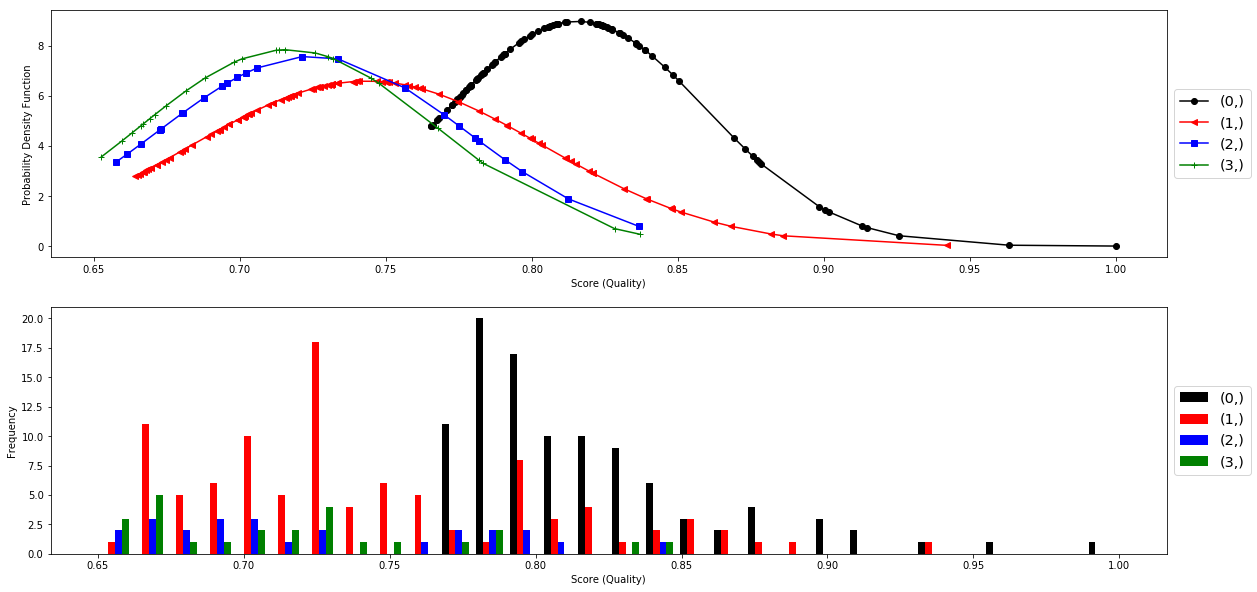

Group  0 :  100.0
Group  1 :  100.0
Group  2 :  25.0
Group  3 :  25.0
Size of data set:  250
Utility:  45.7578690929


[{'Group': 0,
  'Index': 654,
  'K': 1,
  'Score': 1.0,
  'Utility': 0.91023922662683732},
 {'Group': 0,
  'Index': 891,
  'K': 2,
  'Score': 0.9634788985234082,
  'Utility': 0.69500311445044083},
 {'Group': 1,
  'Index': 827,
  'K': 3,
  'Score': 0.9420066211780169,
  'Utility': 0.58530162232436422},
 {'Group': 0,
  'Index': 769,
  'K': 4,
  'Score': 0.9257552084212175,
  'Utility': 0.5166738194050462},
 {'Group': 0,
  'Index': 263,
  'K': 5,
  'Score': 0.9148915339734488,
  'Utility': 0.47016124275707383},
 {'Group': 0,
  'Index': 30,
  'K': 6,
  'Score': 0.9129079211152771,
  'Utility': 0.43901591019375447},
 {'Group': 0,
  'Index': 808,
  'K': 7,
  'Score': 0.9017068827878809,
  'Utility': 0.41038448781646847},
 {'Group': 0,
  'Index': 243,
  'K': 8,
  'Score': 0.9002629392657567,
  'Utility': 0.39097922678512043},
 {'Group': 0,
  'Index': 66,
  'K': 9,
  'Score': 0.8984551526487219,
  'Utility': 0.37468490089653278},
 {'Group': 1,
  'Index': 803,
  'K': 10,
  'Score': 0.8861122927

In [3]:
data_path = "german_credit.json"
attributeName = "Group"
categories =4
attributeQuality = "Score"
k = 250
u_kl = [100,100,100,100]
a = 0.2

data_set = parseDataset(data_path, attributeName, categories)

ranking = celisGreedy(data_set, {attributeName: categories}, attributeQuality, k, u_kl, a)